In [19]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from nn_base_models import FeedforwardNN


The structure of this section will be as so. I will consider 3 classes of IVP problem: \
\
• $y' = -y, y(0)=1$. This has the solution $y = e^{-x}$\
• $y' = y^2, y(0) = 1$. This has the solution $y=\frac{1}{1-x}$\
• $y' = \cos x, y(0) = 0$. This has the solution $y = \sin x$


The structure will be as follows. For each of these classes of subproblem, I will first see how 3 models each with different activation functions performs on these problems, varying number of hidden layers and number of neurons per hidden layer. Each of those results will be scaled and then we can see how varying the learning rate affects the solutions too. For the first case I'll see how the function fits to the region, and then examine how they fit outside the region too. 

For the second case, we will examine how they deal with a singularity. Likely extremely poorly. Similar approach though, and we shall see how they perform.
Third case, we will examine how they deal with a periodic function.

In [ ]:
# Here we define the relevant functions to train the IVP for this first problem

def compute_derivative(y, x):
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dx

# Loss function for the ODE and initial condition
def loss_function(model, x_collocation, x_ic, y_ic, gamma=100):
    x_collocation = x_collocation.requires_grad_(True)
    y_pred = model(x_collocation)
    dy_dx = compute_derivative(y_pred, x_collocation)

    # Residual: dy/dx + y ≈ 0
    ode_residual = dy_dx + y_pred
    loss_ode = torch.mean(ode_residual**2)

    # Initial condition loss
    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic)**2)

    return loss_ode + gamma*loss_ic, loss_ode.item(), loss_ic.item()

# Training loop
def train_ivp(model, epochs=2000, lr=1e-3, n_collocation=100, domain=(0.0, 1.0), verbose=True, gamma=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_collocation = torch.linspace(domain[0], domain[1], n_collocation).view(-1, 1)
    x_collocation = x_collocation.requires_grad_(True)

    # Initial condition remains at x = 0
    x_ic = torch.tensor([[domain[0]]], requires_grad=True)
    y_ic = torch.tensor([[1.0]])

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_ode, loss_ic = loss_function(model, x_collocation, x_ic, y_ic, gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}, ODE = {loss_ode:.6f}, IC = {loss_ic:.6f}")
        loss_history.append(loss.item())

    return loss_history

    


Epoch 0: Total Loss = 52.889828, ODE = 0.082066, IC = 1.056155
Epoch 100: Total Loss = 0.109706, ODE = 0.101471, IC = 0.000165
Epoch 200: Total Loss = 0.029608, ODE = 0.029575, IC = 0.000001
Epoch 300: Total Loss = 0.019499, ODE = 0.019482, IC = 0.000000
Epoch 400: Total Loss = 0.014018, ODE = 0.014008, IC = 0.000000
Epoch 500: Total Loss = 0.010353, ODE = 0.010347, IC = 0.000000
Epoch 600: Total Loss = 0.007962, ODE = 0.007958, IC = 0.000000
Epoch 700: Total Loss = 0.006378, ODE = 0.006376, IC = 0.000000
Epoch 800: Total Loss = 0.005273, ODE = 0.005271, IC = 0.000000
Epoch 900: Total Loss = 0.004444, ODE = 0.004443, IC = 0.000000
Epoch 1000: Total Loss = 0.003780, ODE = 0.003779, IC = 0.000000
Epoch 1100: Total Loss = 0.003226, ODE = 0.003225, IC = 0.000000
Epoch 1200: Total Loss = 0.002756, ODE = 0.002755, IC = 0.000000
Epoch 1300: Total Loss = 0.002356, ODE = 0.002355, IC = 0.000000
Epoch 1400: Total Loss = 0.002016, ODE = 0.002016, IC = 0.000000
Epoch 1500: Total Loss = 0.001729, O

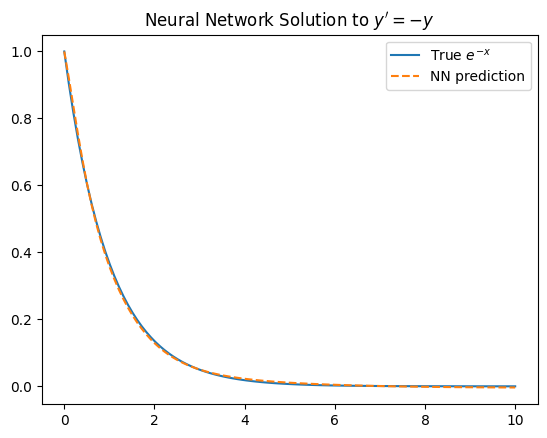

In [ ]:
# sense_check above functions work
model = FeedforwardNN(input_dim=1, output_dim=1, hidden_layers=2, hidden_units=20, activation='tanh')

# Train
loss_history = train_ivp(model, epochs=2000, lr=1e-3, gamma=50, domain=(0.0, 10.0))

# Plot prediction vs true
x_test = torch.linspace(0, 10, 100).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test)
y_true = torch.exp(-x_test)

plt.plot(x_test, y_true, label='True $e^{-x}$')
plt.plot(x_test, y_pred, '--', label='NN prediction')
plt.legend()
plt.title("Neural Network Solution to $y' = -y$")
plt.show()

In [21]:
# Now I will evaluate the best structure for fitting to this simple structure.
activations = ['tanh', 'relu', 'swish']
layer_counts = [i for i in range(20)]
widths = [i for i in range(1, 10)]

# Tracking results
results = []

# Loop through configurations
for act in activations:
    for layers in layer_counts:
        for width in widths:
            config = {
                "activation": act,
                "hidden_layers": layers,
                "hidden_units": width
            }
            print(f"Training model: {config}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)
            
            start = time.time()
            train_ivp(model, epochs=2000, lr=1e-2, verbose=False)  # you can adjust epochs/lr

            # Evaluate MSE on training domain
            x_eval = torch.linspace(0, 1, 100).view(-1, 1)
            y_true = torch.exp(-x_eval)
            with torch.no_grad():
                y_pred = model(x_eval)
                mse = torch.mean((y_pred - y_true)**2).item()
            duration = time.time() - start

            # Store results
            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })


Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 4}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 5}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 6}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 7}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 8}
Training model: {'activation': 'tanh', 'hidden_layers': 0, 'hidden_units': 9}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidd

In [23]:
results_df = pd.DataFrame(results)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])